### 0. Import libraries

In [35]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn.utils.rnn import pad_sequence

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# pytorch model summary 
from pytorch_model_summary import summary

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *

## 1. Define model

In [36]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_feature_size = dynamic_feature_size
        self.static_feature_size = static_feature_size
        self.hidden_size = hidden_size
        print(hidden_size,self.hidden_size,type(hidden_size),type(self.hidden_size))
        # LSTM module for dynamic features
        self.dynamic_rnn = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size + static_feature_size, hidden_size)  
        self.relu = nn.ReLU() 
        
        # Second Fully connected layer
        self.fc2 = nn.Linear(hidden_size, 3)
    
    def forward(self, dynamic_features, static_features):
        # Pass dynaamic features through LSTM
        _, (h_n, _) = self.dynamic_rnn(dynamic_features)
        h_n = h_n.squeeze(0)  
        
        # Concatenate dynamic features with static features
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
         # Pass concatenated features through first fully connected layer
        x = self.relu(self.fc1(concatenated_features))  

        # Pass through the second fully connected layer
        output = self.fc2(x)

        return output

## 2. Define training class


In [37]:
def calculate_gaussian_auc(amplitude, mean, std_dev):
    # Define a range of x values to compute the Gaussian function
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    gaussian_curve = amplitude * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    auc = np.trapz(gaussian_curve, x)
    return auc

class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate, loss_type='mse'):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        
        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss(reduction='mean')
        elif loss_type == 'l1':
            self.loss_fn = nn.L1Loss(reduction='mean')
        elif loss_type == 'nll':
            self.loss_fn = nn.NLLLoss(reduction='mean')
        else:
            raise ValueError("Unsupported loss type. Choose from 'mse', 'l1', 'nll'.")
        
        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []
        self.delta_auc_errors = []
        self.learning_rate = learning_rate
        
    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def calculate_delta_auc(self, y_pred, y_true):
        y_pred = y_pred.detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        delta_aucs = []
        
        for i in range(len(y_true)):
            pred_auc = calculate_gaussian_auc(*y_pred[i])
            true_auc = calculate_gaussian_auc(*y_true[i])
            delta_aucs.append((pred_auc, true_auc))
        
        return delta_aucs

    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)

        # Calculate AUCs
        aucs = self.calculate_delta_auc(y_pred, y_true)
        
        # Calculate loss between predicted and true AUCs
        pred_aucs, true_aucs = zip(*aucs)
        pred_aucs = torch.tensor(pred_aucs, dtype=torch.float32, requires_grad=True)
        true_aucs = torch.tensor(true_aucs, dtype=torch.float32)

        loss = self.loss_fn(pred_aucs, true_aucs)
        
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x_dynamic, x_static, y_true = batch
        y_pred = self(x_dynamic, x_static)
        
        # Calculate AUCs
        aucs = self.calculate_delta_auc(y_pred, y_true)
        
        # Calculate loss between predicted and true AUCs
        pred_aucs, true_aucs = zip(*aucs)
        pred_aucs = torch.tensor(pred_aucs, dtype=torch.float32)
        true_aucs = torch.tensor(true_aucs, dtype=torch.float32)

        test_loss = self.loss_fn(pred_aucs, true_aucs)
        
        self.log('test_loss', test_loss)
        self.test_losses.append(test_loss.item())
        
        return {'test_loss': test_loss}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [38]:
CONVERTER = {
            'temperature_sequence': ast.literal_eval, 
            'wind_speed_sequence': ast.literal_eval, 
            'dni_sequence': ast.literal_eval, 
            'dhi_sequence': ast.literal_eval, 
            'global_irradiance_sequence': ast.literal_eval, 
            'gaussian_params': lambda x: [float(i) for i in x.strip('[]').split()]
        }

class SolarPanelDataset(Dataset):
    def __init__(self, synthetic_csv, measurement_csv, transform=None):
        # Load data from both CSVs
        self.synthetic_data = pd.read_csv(synthetic_csv, converters=CONVERTER)  
        self.measurement_data = pd.read_csv(measurement_csv, converters=CONVERTER) 
        
        # Optionally apply transformations/pre-processing
        self.transform = transform
        
        # Combine data for easy shuffling and splitting
        self.synthetic_data['data_type'] = 'synthetic'
        self.measurement_data['data_type'] = 'measurement'
        self.data_frame = pd.concat([self.synthetic_data, self.measurement_data], ignore_index=True)
        
        #Encode string to int
        self.data_frame['module_type'] = LabelEncoder().fit_transform(self.data_frame['module_type'])
        
           
        # Normalize features
        self.normalize_features()

        # Normalize outputs
        self.normalize_outputs()

    def normalize_features(self):
        # Normalize static numeric features
        for feature in ['tilt', 'azimuth']:
            mean = self.data_frame[feature].mean()
            std = self.data_frame[feature].std()
            if std > 0:
                self.data_frame[feature] = (self.data_frame[feature] - mean) / std
            else:
                self.data_frame[feature] = 0  

        # Normalizing dynamic features
        dynamic_cols = ['temperature_sequence', 'wind_speed_sequence', 'dni_sequence', 'dhi_sequence', 'global_irradiance_sequence']
        for col in dynamic_cols:
            col_data = np.concatenate(self.data_frame[col].values)
            mean = col_data.mean()
            std = col_data.std()
            if std > 0:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: (np.array(x) - mean) / std)
            else:
                self.data_frame[col] = self.data_frame[col].apply(lambda x: np.zeros_like(x))  

    def normalize_outputs(self):
        # Normalize Gaussian output parameters using min-max scaling
        gaussian_array = np.array(self.data_frame['gaussian_params'].tolist())
        self.output_mins = gaussian_array.min(axis=0)
        self.output_maxs = gaussian_array.max(axis=0)

        # Avoid division by zero in case max == min
        range = self.output_maxs - self.output_mins
        range[range == 0] = 1  # prevent division by zero

        normalized_gaussian = (gaussian_array - self.output_mins) / range
        self.data_frame['gaussian_params'] = list(normalized_gaussian)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][[ 'tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features)
        
        # Dynamic features 
        dynamic_features = np.column_stack([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features)

        # Gaussian parameters as output, normalized
        outputs = torch.tensor(self.data_frame.iloc[idx]['gaussian_params'])

        return dynamic_features, static_features, outputs

    def denormalize_output(self, normalized_output):
        # Convert normalized output back to original scale
        denormalized_output = normalized_output * (self.output_maxs - self.output_mins) + self.output_mins
        return denormalized_output
    # def denormalize_output(self, normalized_output):
    #     # Convert normalized output back to original scale
    #     denormalized_output = normalized_output.numpy() * (self.output_maxs - self.output_mins) + self.output_mins
    #     return denormalized_output
    


dataset = SolarPanelDataset('energy_data/dataset_to_train_model.csv', 'energy_data/merged_solar_weather_data.csv')


In [39]:
def custom_collate_fn(batch):
    dynamic_features, static_features, outputs = zip(*batch)

    # Pad the dynamic features
    padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
    padded_dynamic_features = torch.stack(padded_dynamic_features, dim=1)

    # Convert static features and outputs to tensors
    static_features = torch.stack([torch.tensor(static) for static in static_features])
    outputs = torch.stack([torch.tensor(output) for output in outputs])

    return padded_dynamic_features, static_features, outputs


def create_data_loaders(dataset, train_ratio, synthetic_ratio_in_train,batch_size):

    # Determine sizes
    total_count = len(dataset.data_frame)
    train_count = int(train_ratio * total_count)
    test_count = total_count - train_count
    
    # Split dataset into training and testing
    train_data, test_data = random_split(dataset, [train_count, test_count])

    # Further split test data by synthetic and measurement
    test_synthetic_data = Subset(test_data, [i for i in range(len(test_data)) if test_data.dataset.data_frame.iloc[test_data.indices[i]]['data_type'] == 'synthetic'])
    test_measurement_data = Subset(test_data, [i for i in range(len(test_data)) if test_data.dataset.data_frame.iloc[test_data.indices[i]]['data_type'] == 'measurement'])

    # Calculate specific train splits for synthetic and measurement data
    num_train_synthetic = int(len(train_data) * synthetic_ratio_in_train)
    num_train_measurement = len(train_data) - num_train_synthetic
    
    # # Split training data into synthetic and measurement
    # train_synthetic_data = Subset(train_data, [i for i in range(num_train_synthetic) if train_data.dataset.full_data.iloc[train_data.indices[i]]['data_type'] == 'synthetic'])
    # train_measurement_data = Subset(train_data, [i for i in range(num_train_measurement, len(train_data)) if train_data.dataset.full_data.iloc[train_data.indices[i]]['data_type'] == 'measurement'])

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
    test_synthetic_loader = DataLoader(test_synthetic_data, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
    test_measurement_loader = DataLoader(test_measurement_data, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

    return train_loader, test_synthetic_loader, test_measurement_loader

BATCHSIZE = 16

train_loader, test_synthetic_loader, test_measurement_loader = create_data_loaders(
    dataset,
    train_ratio=0.5,
    synthetic_ratio_in_train=0.6,
    batch_size=BATCHSIZE
)

for i, data in enumerate(train_loader):
    if i > 1:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) # Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape) # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) # Gaussian: Amplitude, Mean, standard deviation (normalized)

    # Example to denormalize the output for the first batch
    #if i == 0:
    #    denormalized_outputs = [dataset.denormalize_output(output) for output in outputs]
    #     print("Denormalized Outputs:", denormalized_outputs)

Static Inputs: tensor([[ 1.3081,  1.3751,  1.0000],
        [-0.8427, -0.7687,  0.0000],
        [-0.5355, -0.1712,  0.0000],
        [ 1.2282, -1.4827,  0.0000],
        [-0.8404, -1.4958,  0.0000],
        [ 1.6521,  0.4704,  0.0000],
        [-0.3091,  1.3818,  0.0000],
        [ 1.3297, -1.1443,  0.0000],
        [ 0.2538,  0.7602,  0.0000],
        [-0.2899,  0.2453,  0.0000],
        [ 1.1974,  0.8657,  0.0000],
        [-1.0916,  1.3559,  0.0000],
        [ 0.0174, -0.9837,  0.0000],
        [ 0.9144, -0.5770,  1.0000],
        [ 0.6132, -0.1304,  1.0000],
        [-1.4604, -0.0772,  0.0000]])
Dynamic Inputs Shape: torch.Size([16, 24, 5])
Outputs: tensor([[6.8888e-04, 4.5689e-01, 5.6725e-01],
        [3.6318e-03, 3.1999e-01, 6.5770e-01],
        [4.2006e-03, 3.6076e-01, 6.5230e-01],
        [5.0232e-03, 8.8036e-02, 5.3052e-01],
        [1.1717e-03, 4.7596e-01, 5.6082e-01],
        [5.2193e-03, 4.8811e-01, 2.2543e-01],
        [1.1219e-03, 4.1660e-01, 5.7665e-01],
        [2.0201

C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_features = torch.stack([torch.tensor(static) for static in static_features])
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(

## 4. Train model

In [40]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 3
hidden_size = 128
learning_rate = 1e-3

# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size, learning_rate, loss_type='mse')
model = train_module.model 
print(model)
#print(summary(model, [(dynamic_feature_size,), (static_feature_size,)]))

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=2, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=train_loader)
trained_model = train_module.model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 86.4 K
1 | loss_fn | MSELoss               | 0     
--------------------------------------------------
86.4 K    Trainable params
0         Non-trainable params
86.4 K    Total params
0.346     Total estimated model params size (MB)


128 128 <class 'int'> <class 'int'>
EnergyPredictionModel(
  (dynamic_rnn): LSTM(5, 128, batch_first=True)
  (fc1): Linear(in_features=131, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Log directory contents: ['version_10', 'version_11', 'version_12', 'version_13', 'version_14', 'version_15', 'version_16', 'version_17', 'version_18', 'version_19', 'version_20', 'version_21', 'version_22', 'version_23', 'version_24', 'version_25', 'version_26', 'version_27', 'version_28', 'version_29', 'version_30', 'version_31', 'version_32', 'version_33', 'version_34', 'version_35', 'version_36', 'version_37', 'version_38', 'version_39', 'version_40', 'version_41', 'version_42', 'version_43', 'version_44', 'version_45', 'version_46', 'version_47', 'version_48', 'version_49', 'version_50', 'version_51', 'version_52', 'version_53', 'version_54', 'version_55', 'version_56', 'version_57', 'version_58', 'version_59', 'version_6', 'version_60', 

c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_features = torch.stack([torch.tensor(static) for static in static_features])
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(

## 5. Inspect performance

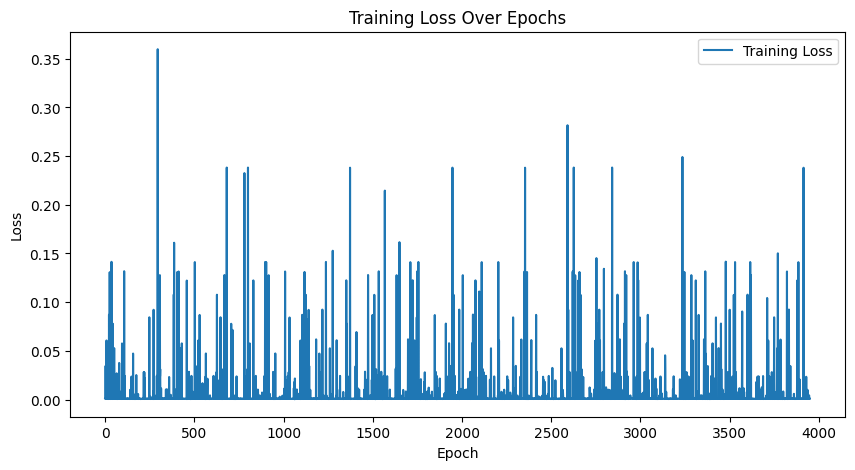

In [41]:
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# for i in  train_module.train_losses:
#     print(i)


#### Launch tensorboard for advanced training insights

In [42]:
# #Launch tensorboard for advanced training insights.
# os.system(f"taskkill /pid 19988 /F")

# # Reload the TensorBoard extension to avoid errors about it being already loaded
# %reload_ext tensorboard

# # Start TensorBoard
# %tensorboard --logdir tb_logs/my_model

## Test model

In [43]:
# Test the model on synthetic data
print("Testing on synthetic data:")
trainer.test(train_module, dataloaders=test_synthetic_loader)

# Test the model on measurement data
print("Testing on measurement data:")
trainer.test(train_module, dataloaders=test_measurement_loader)

Testing on synthetic data:


c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_features = torch.stack([torch.tensor(static) for static in static_features])
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
└───────────────────────────┴───────────────────────────┘

Testing on measurement data:


c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_features = torch.stack([torch.tensor(static) for static in static_features])
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.9506754875183105     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9506754875183105}]

### Inference with tested model

C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_features = torch.stack([torch.tensor(static) for static in static_features])
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(

tensor([[-0.2013, -0.0676, -0.2552]]) torch.Size([1, 3])
[[-0.20127845 -0.06759609 -0.25518557]] (1, 3)


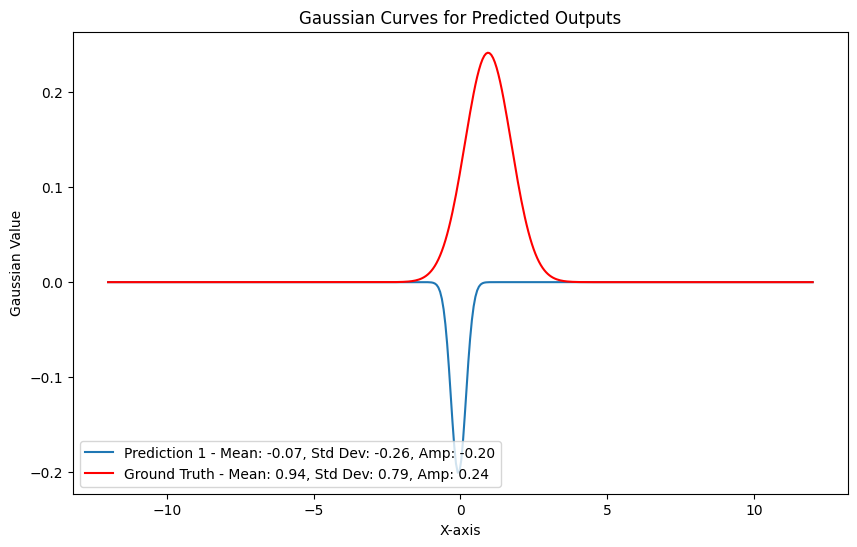

In [44]:
# Load the trained model
trained_model = train_module 
trained_model.eval() 

# Get a single sample from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(test_measurement_loader))
sample =1
# Predict using a single example
with torch.no_grad():
    predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
print(predictions,predictions.shape)

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves
def plot_gaussian(x, predictions,ground_truth, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, label in enumerate(labels):
        a, b, c = predictions[i]
        y = gaussian(x, a, b, c)
        ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
     # Plot ground truth Gaussian curves
    gt_a, gt_b, gt_c = ground_truth[0]
    gt_y = gaussian(x, gt_a, gt_b, gt_c)
    ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

    ax.set_title('Gaussian Curves for Predicted Outputs')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Gaussian Value')
    ax.legend()
    plt.show()

# Prepare x-axis for the plot
x_values = np.linspace(-12, 12, 400)

# Reshape predictions if necessary and convert to numpy if still in tensor form
predictions = predictions.squeeze().numpy().reshape(1, -1)
predictions = predictions
print(predictions, predictions.shape)
ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# Plot the Gaussian curve for the predicted values
plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])

C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_dynamic_features = [pad_sequence([torch.tensor(seq) for seq in feature], batch_first=True) for feature in zip(*dynamic_features)]
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  static_features = torch.stack([torch.tensor(static) for static in static_features])
C:\Users\denni\AppData\Local\Temp\ipykernel_18228\1380729598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(

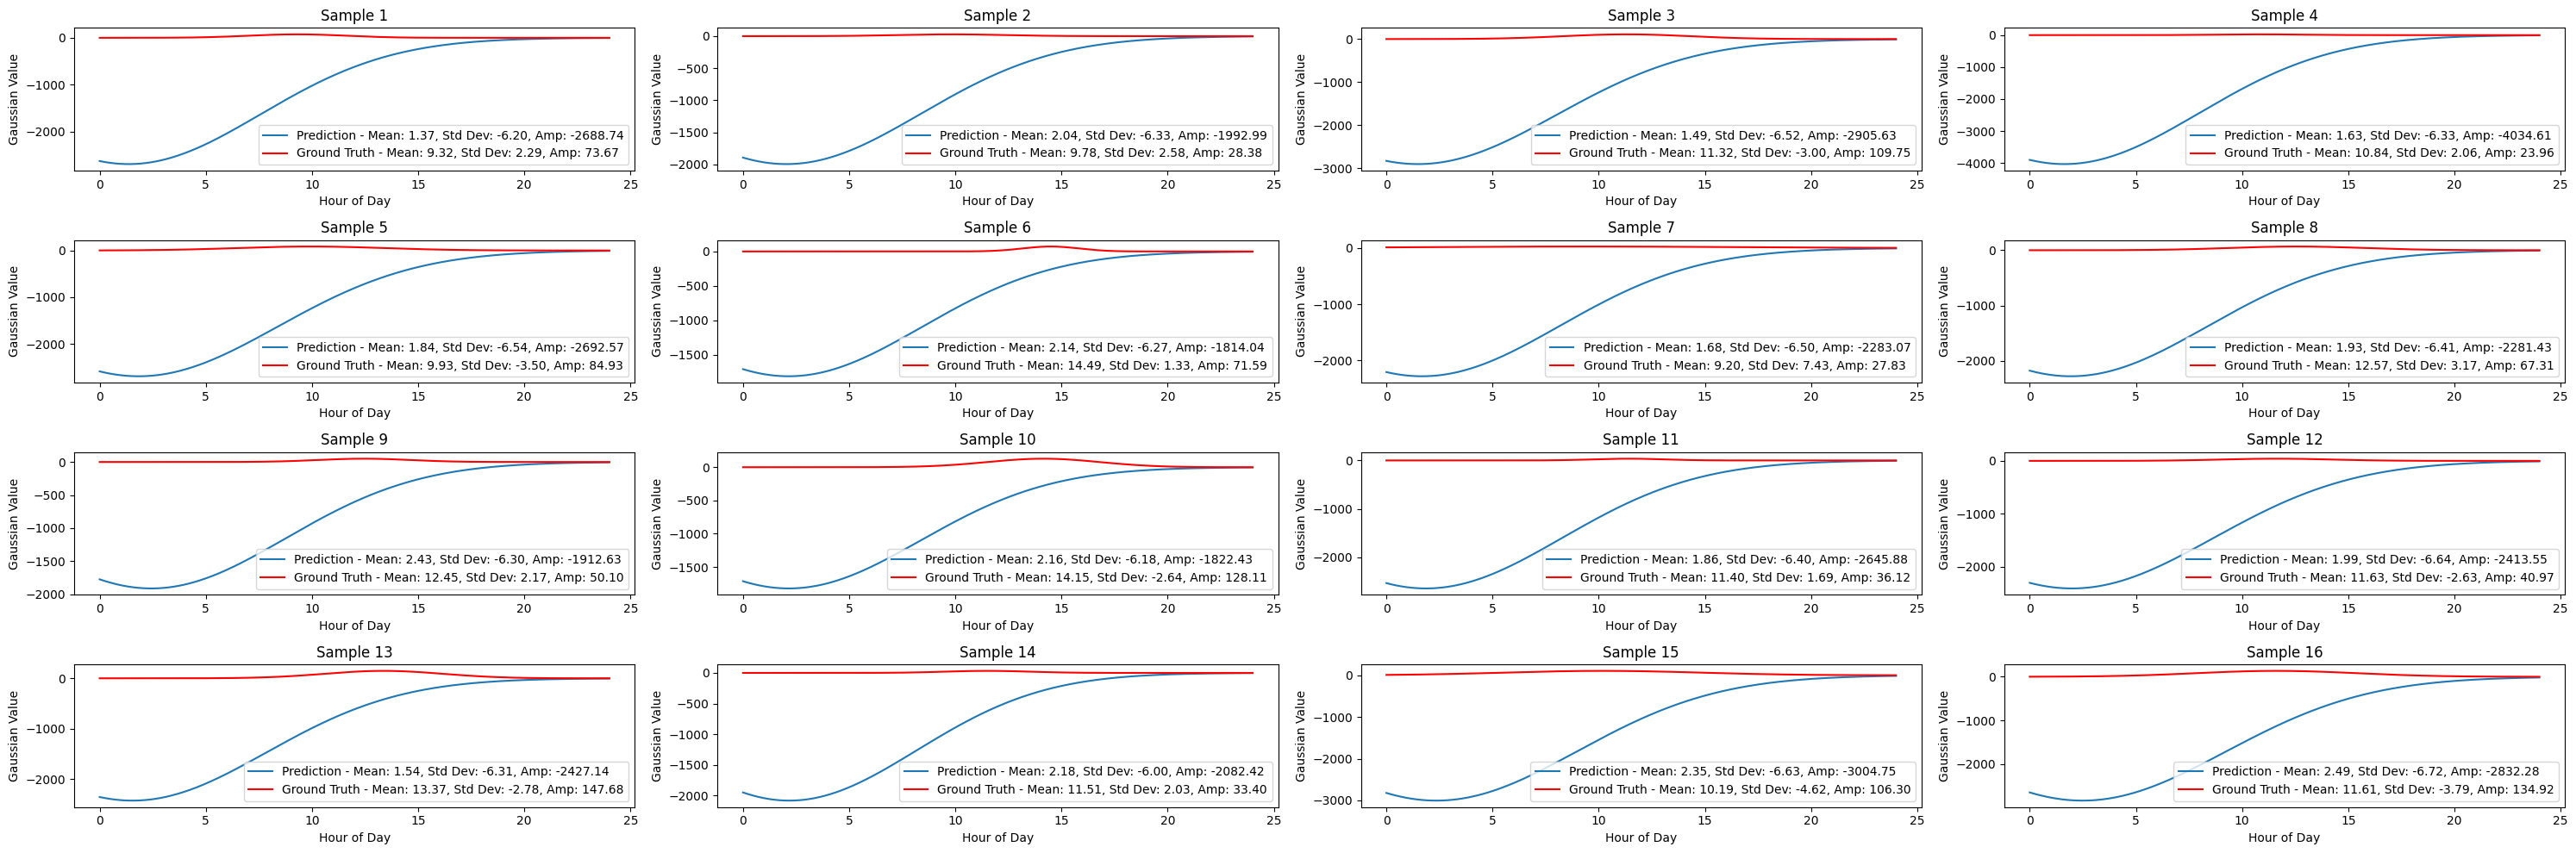

In [47]:
# Load the trained model
trained_model = train_module
trained_model.eval()

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves for multiple samples
def plot_gaussian(samples, x, predictions, ground_truth, labels, rows, cols, dataset):
    fig, axes = plt.subplots(rows, cols, figsize=(30, 10))
    axes = axes.flatten()
    
    for i in range(samples):
        ax = axes[i]
        
        # Denormalize predictions and ground truth
        pred_a, pred_b, pred_c = dataset.denormalize_output(predictions[i])
        gt_a, gt_b, gt_c = dataset.denormalize_output(ground_truth[i])
        
        # Calculate Gaussian curves
        pred_y = gaussian(x, pred_a, pred_b, pred_c)
        gt_y = gaussian(x, gt_a, gt_b, gt_c)
        
        # Plot curves
        ax.plot(x, pred_y, label=f'Prediction - Mean: {pred_b:.2f}, Std Dev: {pred_c:.2f}, Amp: {pred_a:.2f}')
        ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Gaussian Value')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Prepare x-axis for the plot (hours of the day)
x_values = np.linspace(0, 24, 400)

# Number of samples to plot and subplots configuration
num_samples = 16 
rows = 4
cols = 4  

# Get multiple samples from the data loader
samples_dynamic, samples_static, ground_truth = next(iter(test_synthetic_loader))
samples_dynamic = samples_dynamic[:num_samples]
samples_static = samples_static[:num_samples]
ground_truth = ground_truth[:num_samples]

# Predict using the samples
with torch.no_grad():
    predictions = trained_model(samples_dynamic, samples_static)

# Reshape predictions and ground truth if necessary and convert to numpy if still in tensor form
predictions = predictions.numpy()
ground_truth = ground_truth.numpy()

# Plot the Gaussian curves for the predicted values and ground truth
plot_gaussian(num_samples, x_values, predictions, ground_truth, labels=["Prediction"], rows=rows, cols=cols, dataset=dataset)
